In [6]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils

from skimage import exposure
from skimage import feature
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

#from skimage import segmentation
#from skimage import filters
#from skimage import measure
#from skimage.color import rgb2gray
#import scipy.misc
#from PIL import Image

In [7]:
def processTrainImage(imagePath):
    # load the image, convert it to grayscale, and detect edges
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edged = imutils.auto_canny(gray)
    
    # find contours in edge map, keeping only the largest one which is presumed to be the logo
    image, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(contours, key=cv2.contourArea)
    
    # extract the logo of the icon and resize it to canonical width and height
    (x, y, w, h) = cv2.boundingRect(c)
    logo = gray[y:y + h, x:x + w]
    logo = cv2.resize(logo, (60, 60))
    plt.imshow(logo, cmap="gray")
    
    # extract Histogram of Oriented Gradients from the logo
    H = feature.hog(logo, orientations=9, pixels_per_cell=(5, 5),
                    cells_per_block=(2, 2), transform_sqrt=True)
    
    # update the data and labels
    data.append(H)
    labels.append('oberunterHitze')

In [8]:
def processTestImage(imagePath):    
    # load the test image, convert it to grayscale, and resize it to the canonical size
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # resize image to 20% of original size
    m, n = tuple(round(0.2*x) for x in gray.shape)    
    logo = cv2.resize(gray, (n, m))#(m, n))    

    # extract Histogram of Oriented Gradients from test image and predict the make of the logo
    (H, hogImage) = feature.hog(logo, orientations=9, pixels_per_cell=(10, 10),
        cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
     
    #Kneighborclass
    #pred = model.predict(H.reshape(1, -1))[0]
    # one class svm
    pred = clf.predict(H.reshape(1, -1))
    
    # visualize the HOG image
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")
    cv2.imshow("HOG Image", hogImage)
 
    # draw the prediction on the test image and display it
    cv2.putText(image, pred.title(), (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1.0,
        (0, 255, 0), 3)
    #cv2.imshow("Test Image", image)
    cv2.waitKey(0)

In [9]:
data = []
labels = []

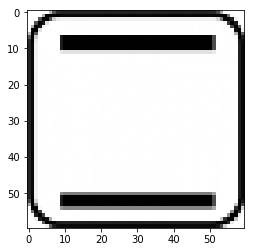

In [10]:
# TRAIN with all images 
rootdir = os.getcwd()
# loop over the image paths in the training set
for subdir, dirs, files in os.walk(rootdir):
    # train files
    if subdir.split('HOG\\')[-1] == 'train':
        for img in files:
            processTrainImage(subdir+'\\'+img)  

In [12]:
# "train" the nearest neighbors classifier
#model = KNeighborsClassifier(n_neighbors=1)
#model.fit(data, labels)

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(data, labels)
print(clf)

print(len(data), len(labels))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)
5 5
[array([ 0.21715382,  0.        ,  0.07548038, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.02222116,  0.01470271,  0.37814932, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.08050904,  0.        ,  0.02941397, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.00739302,  0.00081959,  0.00207343, ...,  0.        ,
        0.00142939,  0.00328988]), array([ 0.00028789,  0.02023233,  0.14363935, ...,  0.        ,
        0.        ,  0.        ])] ['oberunterHitze', 'oberunterHitze', 'oberunterHitze', 'oberunterHitze', 'oberunterHitze']


In [183]:
 # TEST all images
for subdir, dirs, files in os.walk(rootdir):    
    # test files
    if subdir.split('HOG\\')[-1] == 'test':
        for img in files:
            processTestImage(subdir+'\\'+img)

ValueError: X.shape[1] = 4608 should be equal to 4356, the number of features at training time